In [1]:
import openmc
import numpy as np

%env OPENMC_CROSS_SECTIONS /Users/hallj/tokamak_radiation_environment/endfb-viii.0-hdf5/cross_sections.xml

env: OPENMC_CROSS_SECTIONS=/Users/hallj/tokamak_radiation_environment/endfb-viii.0-hdf5/cross_sections.xml


In [2]:
# define materials
dt_plasma = openmc.Material(name='dt_plasma')
dt_plasma.add_nuclide('H2', 1.0)
dt_plasma.add_nuclide('H3', 1.0)
dt_plasma.set_density('g/cm3', 1e-5)

flibe = openmc.Material(name="flibe")
flibe.add_element("Li", 2.0, "ao")
flibe.add_element("Be", 1.0, "ao")
flibe.add_element("F", 4.0, "ao")
flibe.set_density("g/cm3", 1.94)

# Inconel 718 -
inconel718 = openmc.Material(name='inconel718')
inconel718.add_element('Ni', 53.0, 'wo')
inconel718.add_element('Cr', 19.06, 'wo')
inconel718.add_element('Nb', 5.08, 'wo')
inconel718.add_element('Mo', 3.04, 'wo')
inconel718.add_element('Ti', 0.93, 'wo')
inconel718.add_element('Al', 0.52, 'wo')
inconel718.add_element('Co', 0.11, 'wo')
inconel718.add_element('Cu', 0.02, 'wo')
inconel718.add_element('C', 0.021, 'wo')
inconel718.add_element('Fe', 18.15, 'wo')
inconel718.set_density('g/cm3', 8.19)

eurofer = openmc.Material(name='eurofer')
eurofer.add_element('Cr', 8.99866, 'wo')
eurofer.add_element('C', 0.109997, 'wo')
eurofer.add_element('W', 1.5, 'wo')
eurofer.add_element('V', 0.2, 'wo')
eurofer.add_element('Ta', 0.07, 'wo')
eurofer.add_element('B', 0.001, 'wo')
eurofer.add_element('N', 0.03, 'wo')
eurofer.add_element('O', 0.01, 'wo')
eurofer.add_element('S', 0.001, 'wo')
eurofer.add_element('Fe', 88.661, 'wo')
eurofer.add_element('Mn', 0.4, 'wo')
eurofer.add_element('P', 0.005, 'wo')
eurofer.add_element('Ti', 0.01, 'wo')
eurofer.set_density('g/cm3', 7.798)


In [15]:
# Define basic toroidal geometry
bigsphere = openmc.Sphere(r=1000, boundary_type="vacuum")
plasma = openmc.ZTorus(x0=0,y0=0,z0=0,a=680,b=120,c=120)
vv = openmc.ZTorus(x0=0,y0=0,z0=0,a=680,b=125,c=125)
blanket_tank = openmc.ZTorus(x0=0,y0=0,z0=0,a=680,b=127,c=127)
tank_divider_in = openmc.ZTorus(x0=0,y0=0,z0=0,a=680,b=150,c=150)
tank_divider_out = openmc.ZTorus(x0=0,y0=0,z0=0,a=680,b=152,c=152)
burner_tank = openmc.ZTorus(x0=0,y0=0,z0=0,a=680,b=250,c=250)
burner_tank_volume = (2*np.pi**2*250**2 * 680) - (2*np.pi**2*152**2 * 680)
print(burner_tank_volume)

528799191.58003014


In [4]:
plasma_cell = openmc.Cell()
plasma_cell.region = -plasma
plasma_cell.fill = dt_plasma

sol_cell = openmc.Cell()
sol_cell.region = +plasma & -vv

vv_cell = openmc.Cell()
vv_cell.region = +vv & -blanket_tank
vv_cell.fill = inconel718

blanket1_cell = openmc.Cell()
blanket1_cell.region = +blanket_tank & -tank_divider_in
blanket1_cell.fill = flibe

tank_divider_cell = openmc.Cell()
tank_divider_cell.region = +tank_divider_in & -tank_divider_out
tank_divider_cell.fill = inconel718

blanket2_cell = openmc.Cell()
blanket2_cell.region = +tank_divider_out & -burner_tank
blanket2_cell.fill = flibe

container_cell = openmc.Cell()
container_cell.region = +burner_tank & -bigsphere

universe = openmc.Universe()
universe.add_cell(plasma_cell)
universe.add_cell(sol_cell)
universe.add_cell(vv_cell)
universe.add_cell(blanket1_cell)
universe.add_cell(tank_divider_cell)
universe.add_cell(blanket2_cell)
universe.add_cell(container_cell)


<Axes: xlabel='x [cm]', ylabel='z [cm]'>

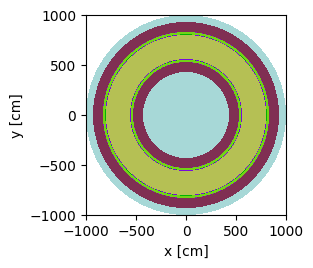

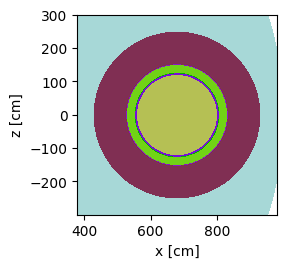

In [6]:
universe.plot(width=(2000.0, 2000.0), origin=(0.0, 0.0, 0.1))
universe.plot(width=(600.0, 600.0), origin=(680.0, 0.0, 0.1), basis='xz')

In [9]:
# source definition
source = openmc.IndependentSource()
source.particle = 'neutron'
radius = openmc.stats.Discrete([680], [1])
z_values = openmc.stats.Discrete([0], [1])
angle = openmc.stats.Uniform(a=np.radians(0), b=np.radians(360))
source.space = openmc.stats.CylindricalIndependent(
    r=radius, phi=angle, z=z_values, origin=(0., 0., 0.))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.muir(e0=14.08e6, m_rat=5, kt=20000)

In [20]:
# settings' settings
settings = openmc.Settings(run_mode='fixed source')
settings.photon_transport = False
settings.source = source
settings.batches = 50
settings.particles = int(1e6) # modify this to shorten simulation, default was 1e6 
settings.statepoint = {'batches': [
    5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]}
settings.output = {'tallies': True}

# %%

burner_cell_filter = openmc.CellFilter(blanket2_cell)
tbr_cell_filter = openmc.CellFilter([blanket1_cell,blanket2_cell])
energy_filter = openmc.EnergyFilter(np.logspace(0,8))

# mesh tally - flux

tally1 = openmc.Tally(tally_id=1, name="flux_burner")
tally1.filters = [burner_cell_filter,energy_filter]
tally1.scores = ["flux"]

# tbr

tally2 = openmc.Tally(tally_id=2, name="tbr_fusion")
tally2.filters = [tbr_cell_filter]
tally2.scores = ["(n,Xt)"]

#power deposition - heating-local

tally3 = openmc.Tally(tally_id=3, name="heating_burner")
tally3.filters = [burner_cell_filter]
tally3.scores = ["heating-local"]

materials = openmc.Materials([dt_plasma,flibe,inconel718,eurofer])
geometry = openmc.Geometry(universe)
tallies = openmc.Tallies([tally1,tally2,tally3])     

model = openmc.Model(materials=materials, geometry=geometry,
                     settings=settings, tallies=tallies)

model.export_to_model_xml()

model.run(threads=8, geometry_debug=True)

/Users/hallj/anaconda3/envs/openmc-env-arm64/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/Users/hallj/anaconda3/envs/openmc-env-arm64/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=2.
  warn(msg, IDWarning)
/Users/hallj/anaconda3/envs/openmc-env-arm64/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################